In [2]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

### Attempt to input fmri dataset (no longer doing this)

Use col Jurado method of processing the NASA video, fmri csv file. The part of the brain we want to model is going to be based off of the dataset. Process the data by remodeling it accurately in nengo.

Then we use the nengo data to model that part of the brain, but this assumes that our spiking data is more accurate than the original fmri because it is less active.

Ideas for making it more accurate: using neurons pool, making a big red blob with noise to represent the idea that only a certain percent of the oxygen goes towards neuron activation and the other goes towards (insert research here)

Amygdala dataset



### Just kidding, project changed and now we are using advanced learning in nengo

Meant to model hyperactive and dissociative responses to trauma in PTSD patients. Neurons learn to over or under fire based on previous traumatic events. In the future, look into repeated trauma, and why patients experience over-reactive states or relive the trauma at times they are safe.

Online learning in nengo. First we are going to create a network of two ensembles. One of them has an initial value of .5, and the other has a goal value meant to represent someone who is learning to overreact to a traumatic event at a value of 1.

The plots show the data before any learning has occured.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

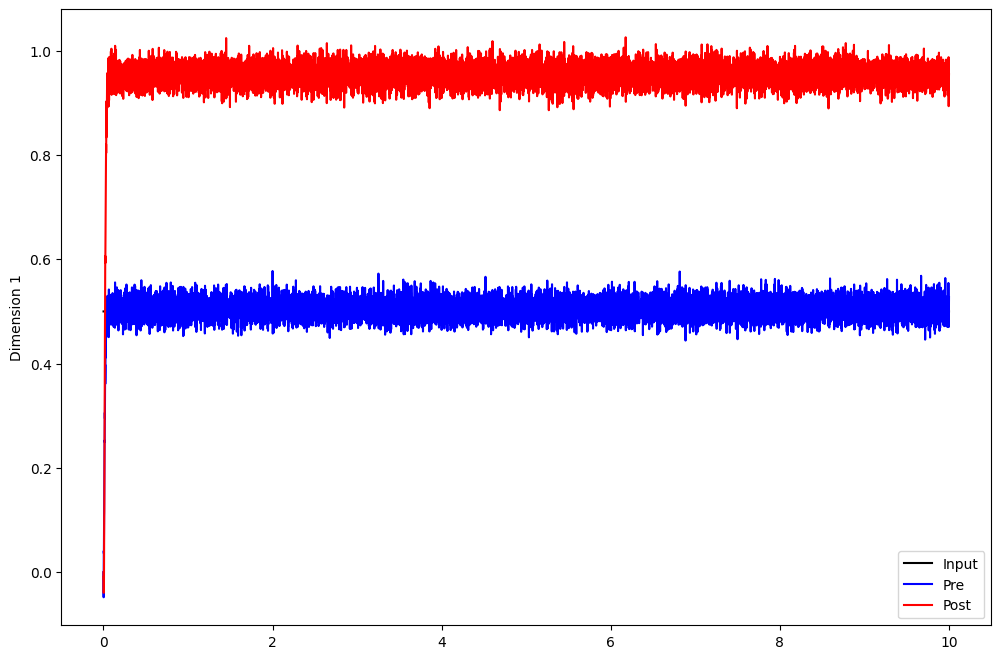

In [3]:
model = nengo.Network(label="Pretrained Hyperactive Response")
with model:
    # input signal, passed from node to ensemble A
    input = nengo.Node(.5)
    A = nengo.Ensemble(60, dimensions=1)
    nengo.Connection(input, A)

    # passed output of ensemble A to ensemble B 
    # train weights with a complicated function (send in a value, return something random)
    B = nengo.Ensemble(60, dimensions=1)
    conn = nengo.Connection(A, B, function=lambda x: 2*x)
    
    inp_p = nengo.Probe(input)
    pre_p = nengo.Probe(A, synapse=0.01)
    post_p = nengo.Probe(B, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(10.0)

plt.figure(figsize=(12, 8))
plt.plot(sim.trange(), sim.data[inp_p].T[0], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_p].T[0], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[post_p].T[0], c="r", label="Post")
plt.ylabel("Dimension 1")
plt.legend(loc="best")


#### Hyperactive Learning Rule Section - Hyperactive is actually normal



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

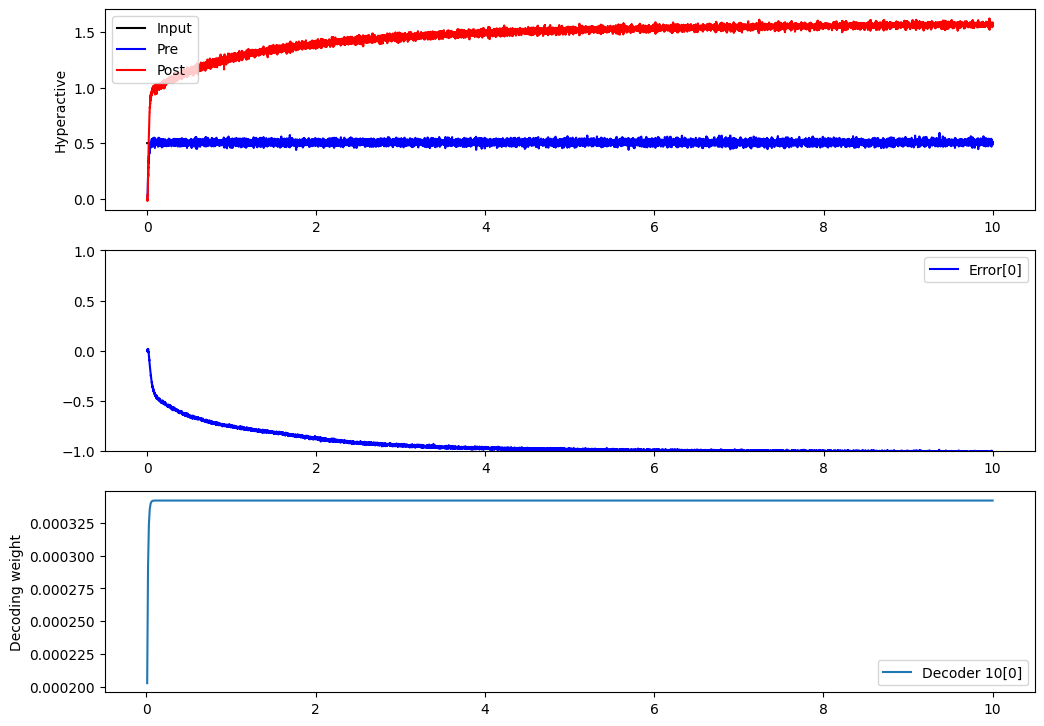

In [4]:
# start of the hyperactive response (learning rule)

with model:
    error = nengo.Ensemble(60, dimensions=2)
    error_probe = nengo.Probe(error, synapse=0.03)

    # Error = actual - target = post - pre
    nengo.Connection(A, error)   
    nengo.Connection(B, error, transform=-1) 
    

    # Add the learning rule to the connection
    conn.learning_rule_type = nengo.PES()

    # Connect the error into the learning rule
    nengo.Connection(error, conn.learning_rule)

    # probe the decoders to see how those change over time to reduce error
    weights_p = nengo.Probe(conn, "weights", synapse=0.01, sample_every=0.01)


    # Running the learning rule for ten seconds
    with nengo.Simulator(model) as sim:
        
        sim.run(10.0)

    # Plotting the learning rule.


    plt.figure(figsize=(12, 12))
    plt.subplot(4, 1, 1)
    plt.plot(sim.trange(), sim.data[inp_p].T[0], c="k", label="Input")
    plt.plot(sim.trange(), sim.data[pre_p].T[0], c="b", label="Pre")
    plt.plot(sim.trange(), sim.data[post_p].T[0], c="r", label="Post")
    plt.ylabel("Hyperactive")
    plt.legend(loc="best")

    plt.subplot(4, 1, 2)
    plt.plot(sim.trange(), sim.data[error_probe], c="b")
    plt.ylim(-1, 1)
    plt.legend(("Error[0]", "Error[1]"), loc="best")
    plt.subplot(4, 1, 3)
    plt.plot(sim.trange(sample_every=0.01), sim.data[weights_p][...,20])
    plt.ylabel("Decoding weight")
    plt.legend(("Decoder 10[0]", "Decoder 10[1]"), loc="best")



### Dissociative Response Initial Network (no training) -- Checkpoint #2 Changes

Creating two error connections... Checkpoint #2: need to make a second branch that contains the desired output, which will be .75 times the input.

The difference will be minimized b/t O and desired output block and an additional "desired output ensemble"

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

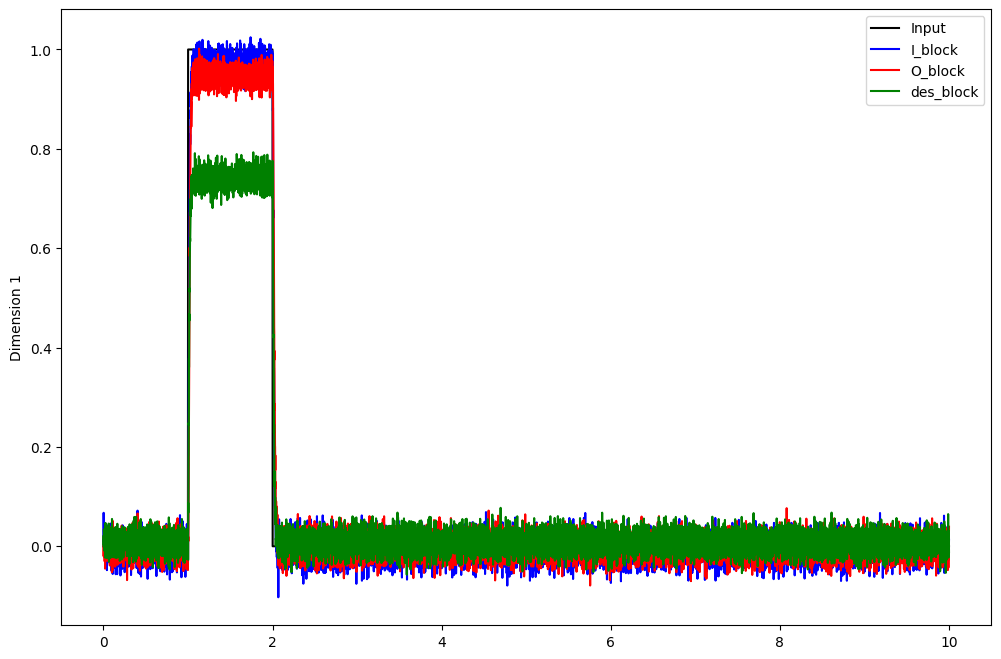

In [34]:
# initial model plot (with no learning) - Creating ensembles and connections
# Plot desired output and output's output 1st, then fix the errors issue later
# In this section, create plots for outputs and desired 

model = nengo.Network(label="Dissociative Neurons Pre-Learning")
with model:
    # input signal, passed from node to ensemble A ... For checkpoint #2, the input should also be sent into ensemble des
    input = nengo.Node(Piecewise({0: 0, 1:1, 2:0})) # attempts piecewise that goes up to 1 from 1-2sec
    I = nengo.Ensemble(60, dimensions=1)
    nengo.Connection(input, I)  # connects input to I
    
    # passed output of ensemble I to ensemble O
    O = nengo.Ensemble(60, dimensions=1) 

    conn = nengo.Connection(I, O) # connecting I to O

    des = nengo.Ensemble(60, dimensions=1)  # desired output is .75 times the input

    # defining the function
with model:

# Define functions - dead function makes it die over time by multiplying by .75

    def dead(x):
        return x*0.75                       
    nengo.Connection(input, des, function=dead)

    # end of creating the function

    # creating all the probes

    des_p = nengo.Probe(des, synapse=.01) # original error probe
    inp_p = nengo.Probe(input) 
    I_p = nengo.Probe(I, synapse=0.01) 
    O_p = nengo.Probe(O, synapse=0.01)

    # creating the simulation

with nengo.Simulator(model) as sim:
    sim.run(10.0)

plt.figure(figsize=(12, 8))
plt.plot(sim.trange(), sim.data[inp_p].T[0], c="k", label="Input")
plt.plot(sim.trange(), sim.data[I_p].T[0], c="b", label="I_block")
plt.plot(sim.trange(), sim.data[O_p].T[0], c="r", label="O_block")
plt.plot(sim.trange(), sim.data[des_p].T[0], c="g", label="des_block")
plt.ylabel("Dimension 1")
plt.legend(loc="best")

### Implementing Dissociative Learning Rule -> Error differences section (minimize the error to reach a goal)

The new goal is called "des", where previously our goal was input A. In this section I was able to show a single pulse decrease to .75 over time to represent numbing reaction/senses to a single traumatic event.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

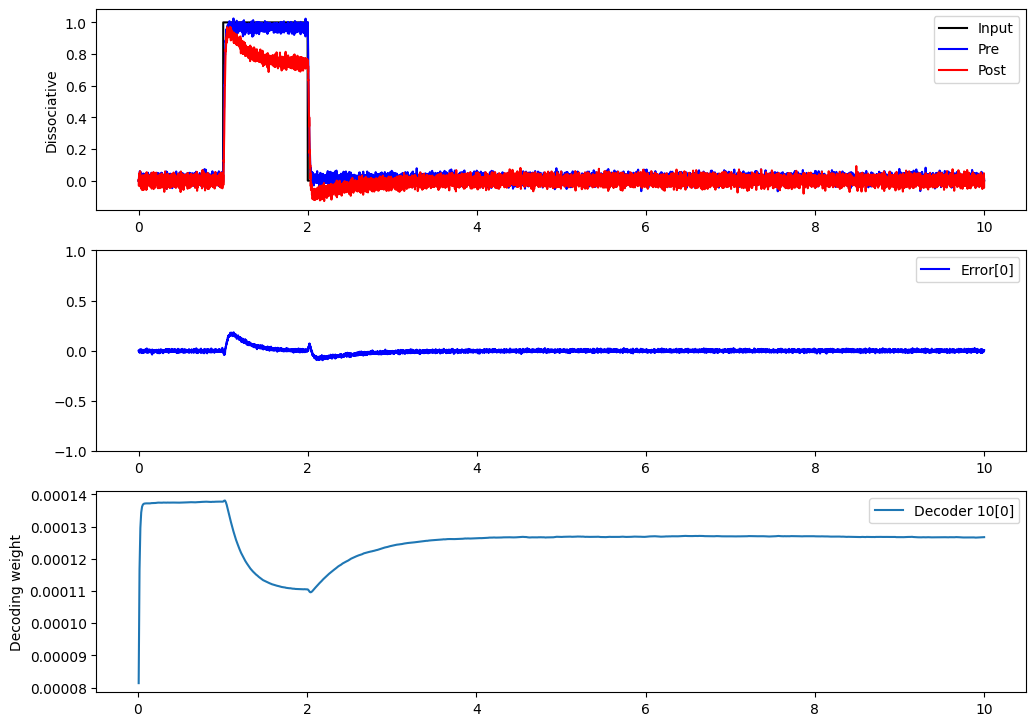

In [35]:
# This is the dissociative response (learning rule)

with model:
    error = nengo.Ensemble(60, dimensions=1)
    error_probe = nengo.Probe(error, synapse=0.03)

    # Error = actual - target = post - pre   
    nengo.Connection(des, error, transform=-1) 
    nengo.Connection(O, error)

    # Add the learning rule to the connection
    conn.learning_rule_type = nengo.PES()

    # Connect the error into the learning rule
    nengo.Connection(error, conn.learning_rule)

    # probe the decoders to see how those change over time to reduce error
    weights_p = nengo.Probe(conn, "weights", synapse=0.01, sample_every=0.01)

    # "run it plot it"

    with nengo.Simulator(model) as sim:
        sim.run(10.0)
        
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.plot(sim.trange(), sim.data[inp_p].T[0], c="k", label="Input")
plt.plot(sim.trange(), sim.data[I_p].T[0], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[O_p].T[0], c="r", label="Post")
plt.ylabel("Dissociative")
plt.legend(loc="best")

plt.subplot(4, 1, 2)
plt.plot(sim.trange(), sim.data[error_probe], c="b")
plt.ylim(-1, 1)
plt.legend(("Error[0]", "Error[1]"), loc="best")
plt.subplot(4, 1, 3)
plt.plot(sim.trange(sample_every=0.01), sim.data[weights_p][...,20])
plt.ylabel("Decoding weight")
plt.legend(("Decoder 10[0]", "Decoder 10[1]"), loc="best")